# 0. IMPORTS

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import inflection
from datetime import datetime
from scipy import stats
import pickle
import random

from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans

from xgboost import XGBClassifier

from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer

from boruta import BorutaPy

pd.set_option('display.max_columns', None)

## 0.1. Help Functions

In [2]:
def snakecase(columns):
    return [inflection.underscore(column) for column in columns]


def cramerv(x, y):
    cm = pd.crosstab(x, y).values
    chi2 = stats.chi2_contingency(cm)[0]
    n = cm.sum()
    r, k = cm.shape
    v = np.sqrt((chi2/n) / min(k-1, r-1))
    
    chi2_corr = max(0, chi2 - (((k-1)*(r-1)) / (n-1)))
    k_corr = k - (k-1)**2 / (n-1)
    r_corr = r - (r-1)**2 / (n-1)
    v_corr = np.sqrt((chi2_corr/n) / min(k_corr-1, r_corr-1))
    
    return v_corr


def ml_error(model_name, y, yhat):
    accuracy = accuracy_score(y, yhat)
    
    return pd.DataFrame({'model_name': model_name,
                         'accuracy': accuracy}, index=[0])


def cross_validation(model, model_name, X, y):
    scores = []
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    for train_lines, valid_lines in kf.split(X):
        X_train = X.iloc[train_lines]
        X_valid = X.iloc[valid_lines]
        y_train = y.iloc[train_lines]
        y_valid = y.iloc[valid_lines]
        
        model.fit(X_train, y_train)
        yhat = model.predict(X_valid)
        accuracy = accuracy_score(y_valid, yhat)
        scores.append(accuracy)
    
    final_score = np.mean(scores)
    
    return pd.DataFrame({'model_name': model_name, 'final_score': final_score}, index=[0])

## 0.2. Load Data

In [3]:
df0 = pd.read_csv('./data/ml_project1_data.csv')

# 1. DATA DESCRIPTION

In [4]:
df1 = df0.copy()

In [5]:
df1.sample(5)
# Feature thet are not in the data dictionary

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
1070,10536,1971,PhD,Together,32892.0,1,0,2014-05-25,78,26,0,15,2,1,2,2,3,0,3,8,0,0,0,0,0,0,3,11,0
94,2230,1970,PhD,Married,23626.0,1,0,2014-05-24,84,27,2,14,0,0,0,3,3,1,3,5,0,0,0,0,0,0,3,11,0
2066,6103,1948,Graduation,Married,42192.0,0,0,2013-09-06,40,40,15,15,17,6,7,1,2,1,3,4,0,0,0,0,0,0,3,11,0
402,7617,1974,Graduation,Single,42373.0,1,1,2013-08-15,83,67,5,61,3,8,19,5,2,1,5,5,0,0,0,0,0,0,3,11,0
1637,10711,1945,Graduation,Married,69755.0,0,0,2013-10-02,23,217,77,373,111,23,93,1,3,6,12,1,0,0,0,0,0,0,3,11,0


In [6]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,2240.0,5592.159821,3246.662198,0.0,2828.25,5458.5,8427.75,11191.0
Year_Birth,2240.0,1968.805804,11.984069,1893.0,1959.00,1970.0,1977.00,1996.0
Income,2216.0,52247.251354,25173.076661,1730.0,35303.00,51381.5,68522.00,666666.0
Kidhome,2240.0,0.444196,0.538398,0.0,0.00,0.0,1.00,2.0
Teenhome,2240.0,0.506250,0.544538,0.0,0.00,0.0,1.00,2.0
Recency,2240.0,49.109375,28.962453,0.0,24.00,49.0,74.00,99.0
MntWines,2240.0,303.935714,336.597393,0.0,23.75,173.5,504.25,1493.0
MntFruits,2240.0,26.302232,39.773434,0.0,1.00,8.0,33.00,199.0
MntMeatProducts,2240.0,166.950000,225.715373,0.0,16.00,67.0,232.00,1725.0
MntFishProducts,2240.0,37.525446,54.628979,0.0,3.00,12.0,50.00,259.0


## 1.1. Rename Columns

In [7]:
cols_old = df1.columns
cols_new = snakecase(cols_old)
df1.columns = cols_new

## 1.2. Data Dimensions

In [8]:
df1.shape

(2240, 29)

## 1.3. Data Types

In [9]:
df1.dtypes

id                         int64
year_birth                 int64
education                 object
marital_status            object
income                   float64
kidhome                    int64
teenhome                   int64
dt_customer               object
recency                    int64
mnt_wines                  int64
mnt_fruits                 int64
mnt_meat_products          int64
mnt_fish_products          int64
mnt_sweet_products         int64
mnt_gold_prods             int64
num_deals_purchases        int64
num_web_purchases          int64
num_catalog_purchases      int64
num_store_purchases        int64
num_web_visits_month       int64
accepted_cmp3              int64
accepted_cmp4              int64
accepted_cmp5              int64
accepted_cmp1              int64
accepted_cmp2              int64
complain                   int64
z_cost_contact             int64
z_revenue                  int64
response                   int64
dtype: object

## 1.4. Check NA

In [10]:
df1.isna().sum()

id                        0
year_birth                0
education                 0
marital_status            0
income                   24
kidhome                   0
teenhome                  0
dt_customer               0
recency                   0
mnt_wines                 0
mnt_fruits                0
mnt_meat_products         0
mnt_fish_products         0
mnt_sweet_products        0
mnt_gold_prods            0
num_deals_purchases       0
num_web_purchases         0
num_catalog_purchases     0
num_store_purchases       0
num_web_visits_month      0
accepted_cmp3             0
accepted_cmp4             0
accepted_cmp5             0
accepted_cmp1             0
accepted_cmp2             0
complain                  0
z_cost_contact            0
z_revenue                 0
response                  0
dtype: int64

## 1.5. Fillout NA

<AxesSubplot:xlabel='income', ylabel='Count'>

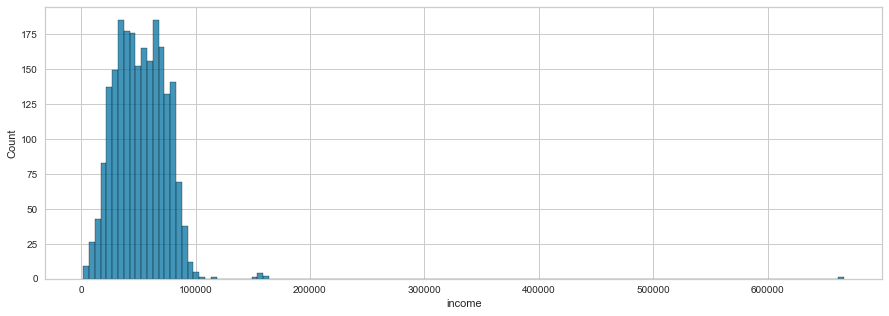

In [11]:
plt.figure(figsize=(15,5))
sns.histplot(data=df1['income'])

In [12]:
# apply median to income's nan and outlier
df1.loc[(df1['income'] > 400000) | (df1['income'].isna()), 'income'] = df1['income'].median()

## 1.6. Change Types

In [13]:
df1['dt_customer'] = pd.to_datetime(df1['dt_customer'])

## 1.7. Descriptive Statistics

### 1.7.1. Numerical Attributes

In [14]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
id,2240.0,5592.159821,3246.662198,0.0,2828.25,5458.5,8427.75,11191.0
year_birth,2240.0,1968.805804,11.984069,1893.0,1959.00,1970.0,1977.00,1996.0
income,2240.0,51963.294866,21405.893812,1730.0,35538.75,51381.5,68275.75,162397.0
kidhome,2240.0,0.444196,0.538398,0.0,0.00,0.0,1.00,2.0
teenhome,2240.0,0.506250,0.544538,0.0,0.00,0.0,1.00,2.0
recency,2240.0,49.109375,28.962453,0.0,24.00,49.0,74.00,99.0
mnt_wines,2240.0,303.935714,336.597393,0.0,23.75,173.5,504.25,1493.0
mnt_fruits,2240.0,26.302232,39.773434,0.0,1.00,8.0,33.00,199.0
mnt_meat_products,2240.0,166.950000,225.715373,0.0,16.00,67.0,232.00,1725.0
mnt_fish_products,2240.0,37.525446,54.628979,0.0,3.00,12.0,50.00,259.0


<AxesSubplot:xlabel='response', ylabel='Count'>

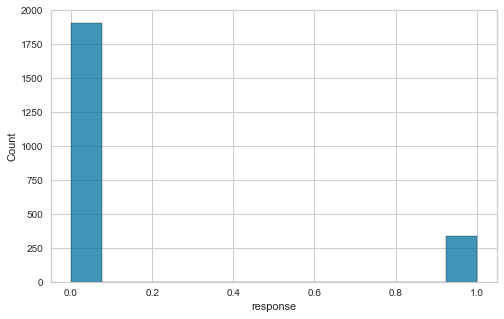

In [15]:
plt.figure(figsize=(8,5))
sns.histplot(data=df1['response'])

### 1.7.2. Categorical Attributes

In [16]:
df1.describe(include=['O'])

,education,marital_status
count,2240,2240
unique,5,8
top,Graduation,Married
freq,1127,864


# 2. FEATURE ENGINEERING

In [17]:
df2 = df1.copy()

## 2.1. Hypothesis Mind Map

![MindMap](img/iFoodMarketingCampaign.jpg)

## 2.2. Hypothesis Creation

### 2.2.1. Product Hypothesis
1. Customers that buy products with discount shouldn't accept the gadget.
2. Customer that buy more Gold products should accept the gadget.

### 2.2.2. Time Hypothesis
3. Customers with recency under 30 should accept more the gadget.
3. Customers with recency under 30 should buy more.
4. Customer that enrolled since more time should accept the gadget.
4. Customer that enrolled since more time should buy more.

### 2.2.3. Customer Hypothesis
5. Customers with higher education should accept the gadget.
5. Customers with higher education should buy more.
6. Customers with lower age should accept the gadget.
6. Customers with lower age should buy more.
7. Customers with higher income should accept the gadget.
7. Customers with higher income should buy more.
8. Customers that often visit the store website should accept the gadget.
8. Customers that often visit the store website should buy more.
9. Customers that are single should accept the gadget.
9. Customers that are single should buy more.
10. Customers with more kids in household should accept the gadget.
10. Customers with more kids in household should buy more.
11. Customers with more teenagers in household should accept the gadget.
11. Customers with more teenagers in household should buy more.
12. Customers that often complains don't should accept the gadget.
12. Customers that often complains don't should buy more.

## 2.3. Feature Engineering

In [18]:
# days since enrolled
df2['days_since_enrolled'] = df2['dt_customer'].apply(lambda x: (x - datetime.today()).days * -1)

# total spent in products
df2['mnt_total'] = df2['mnt_wines'] + df2['mnt_wines'] + df2['mnt_fruits'] + df2['mnt_meat_products'] + df2['mnt_fish_products']  + df2['mnt_sweet_products']

# total number of purchases
df2['num_total_purchases'] = df2['num_web_purchases'] + df2['num_catalog_purchases'] + df2['num_store_purchases']

# compromissed
# I wil assume the follow about marital status
marital_dict = {'Absurd': 0, 'Alone': 0, 'Divorced': 0, 'Married': 1, 'Single': 0, 'Together': 1, 'Widow': 0, 'YOLO': 0}
df2['compromissed'] = df2['marital_status'].map(marital_dict)
df2.loc[df2['marital_status'] == 'Absurd', 'marital_status'] = 'Single'
df2.loc[df2['marital_status'] == 'Alone', 'marital_status'] = 'Single'
df2.loc[df2['marital_status'] == 'YOLO', 'marital_status'] = 'Single'

# accept total
df2['accepted_total'] = df2['accepted_cmp1'] + df2['accepted_cmp2'] + df2['accepted_cmp3'] + df2['accepted_cmp4'] + df2['accepted_cmp5']

# total household_people
df2['household_people'] = df2['kidhome'] + df2['teenhome'] + df2['compromissed']

# Age
df2['age'] = datetime.today().year - df2['year_birth']

# net_profit
df2['net_profit'] = df2['response'] * df2['z_revenue'] - df2['z_cost_contact']

In [19]:
df2.head(2)

,id,year_birth,education,marital_status,income,kidhome,teenhome,dt_customer,recency,mnt_wines,mnt_fruits,mnt_meat_products,mnt_fish_products,mnt_sweet_products,mnt_gold_prods,num_deals_purchases,num_web_purchases,num_catalog_purchases,num_store_purchases,num_web_visits_month,accepted_cmp3,accepted_cmp4,accepted_cmp5,accepted_cmp1,accepted_cmp2,complain,z_cost_contact,z_revenue,response,days_since_enrolled,mnt_total,num_total_purchases,compromissed,accepted_total,household_people,age,net_profit
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1,3157,2164,22,0,0,0,64,8
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0,2607,32,4,0,0,2,67,-3


# 3. FILTERING VARIABLES

In [20]:
df3 = df2.copy()

## 3.1. Line Filtering

In [21]:
# lines didn't filtered

## 3.2. Columns Selection

In [22]:
cols_drop = ['id', 'dt_customer']
df3 = df3.drop(cols_drop, axis=1)

# 4. EXPLORATORY DATA ANALYSIS

In [23]:
df4 = df3.copy()

## 4.1. Univariate Analysis

In [24]:
num_attributes = df4.select_dtypes(include=['int64', 'float64']).drop(['z_cost_contact', 'z_revenue'], axis=1)
cat_attributes = df4.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 4.1.1. Response Variable

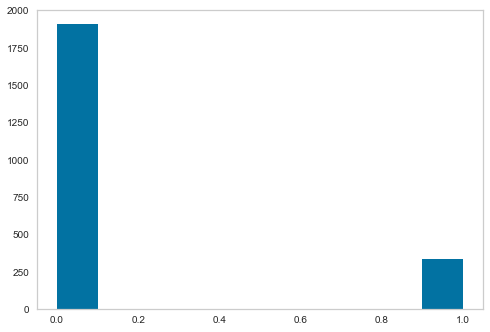

In [25]:
df4['response'].hist(grid=False);

### 4.1.2. Numerical Variable

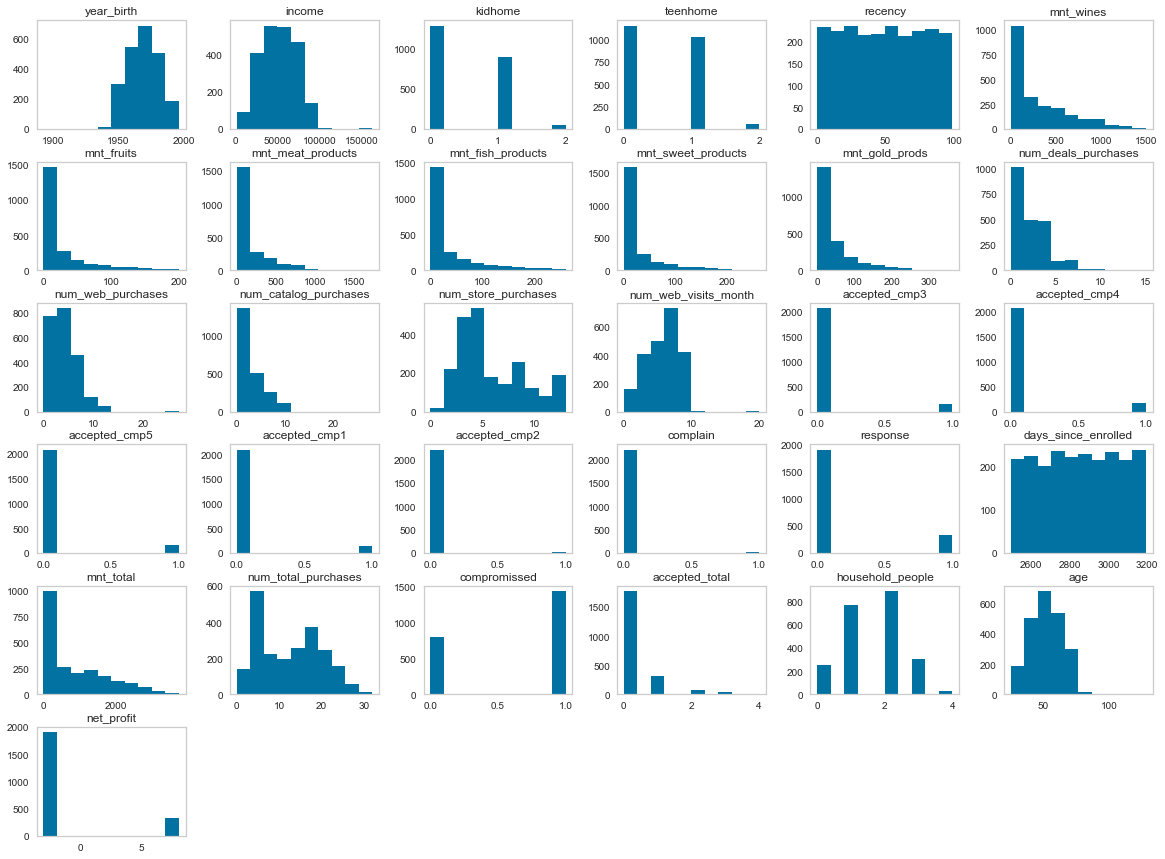

In [26]:
num_attributes.hist(figsize=(20,15), grid=False);

### 4.1.3. Categorical Variable

In [27]:
cat_attributes.columns

Index(['education', 'marital_status'], dtype='object')

<AxesSubplot:xlabel='education', ylabel='response'>

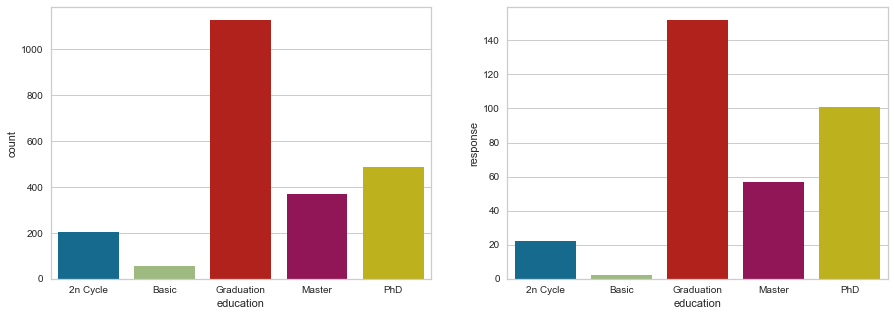

In [28]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.countplot(data=df4.sort_values('education'), x='education')

plt.subplot(1, 2, 2)

aux1 = df4[['education', 'response']].groupby('education').sum().reset_index()
sns.barplot(data=aux1, x='education', y='response')

<AxesSubplot:xlabel='marital_status', ylabel='response'>

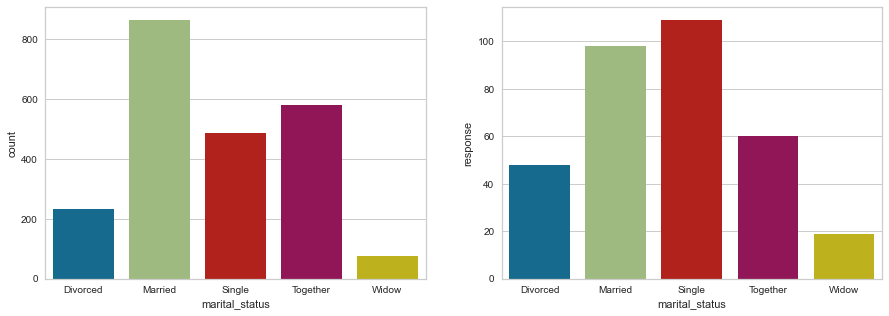

In [29]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.countplot(data=df4.sort_values('marital_status'), x='marital_status')

plt.subplot(1, 2, 2)

aux1 = df4[['marital_status', 'response']].groupby('marital_status').sum().reset_index()
sns.barplot(data=aux1, x='marital_status', y='response')

## 4.2. Bivariate Analysis

### H1. Customers that buy products with discount should't accept the gadget.
**True** - Customers with more discont purchases don't accept the gadget

<AxesSubplot:>

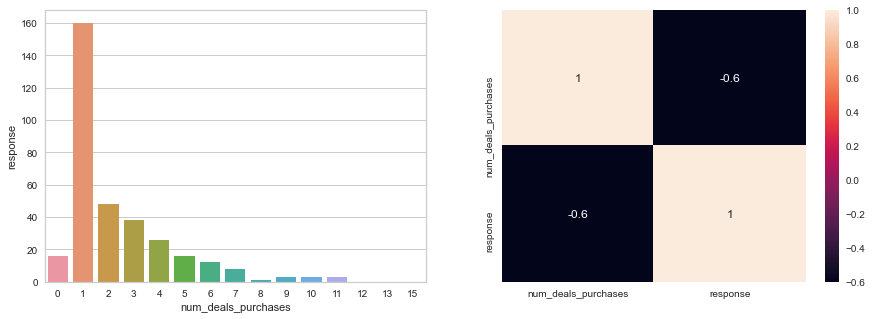

In [30]:
aux1 = df4[['num_deals_purchases', 'response']].groupby('num_deals_purchases').sum().reset_index()

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.barplot(data=aux1, x='num_deals_purchases', y='response');

plt.subplot(1, 2, 2)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### H2. Customer that buy more Gold products should accept the gadget.
**False** - Customers that buy more Gold Products tend not accept the gadget

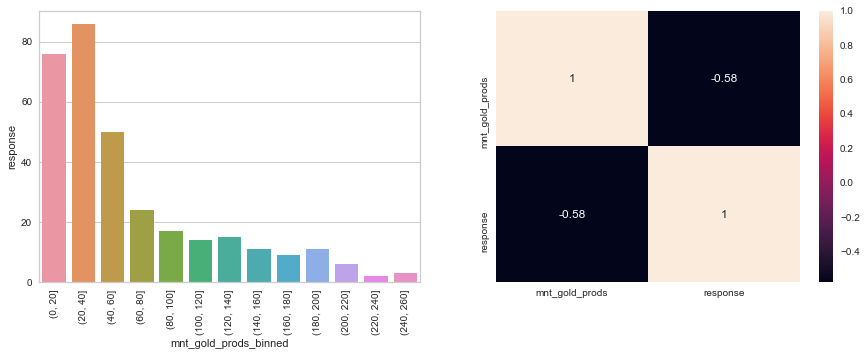

In [31]:
aux1 = df4[['mnt_gold_prods', 'response']].groupby('mnt_gold_prods').sum().reset_index()
bins = list(np.arange(0, 261, 20))
aux1['mnt_gold_prods_binned'] = pd.cut(aux1['mnt_gold_prods'], bins=bins)

aux2 = aux1[['mnt_gold_prods_binned', 'response']].groupby('mnt_gold_prods_binned').sum().reset_index()

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.barplot(data=aux2, x='mnt_gold_prods_binned', y='response');
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H3. Customers with recency under 30 should accept more the gadget.
**True** - Customers with recency under 30 accept more the gadget.

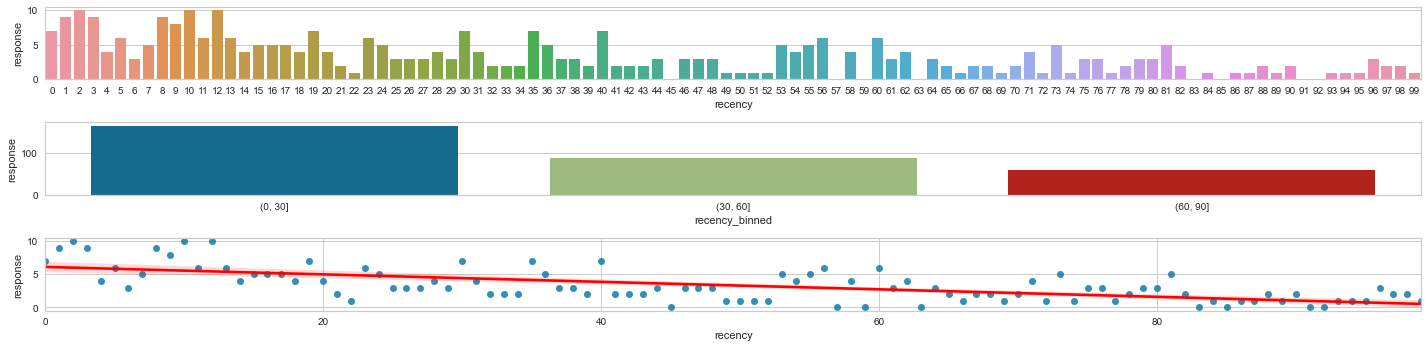

In [32]:
aux1 = df4[['recency', 'response']].groupby('recency').sum().reset_index()
bins=list(np.arange(0 ,120, 30))
aux1['recency_binned'] = pd.cut(aux1['recency'], bins=bins)

aux2 = aux1[['recency_binned', 'response']].groupby('recency_binned').sum().reset_index()

plt.figure(figsize=(20, 5))
plt.subplot(3, 1, 1)
sns.barplot(data=aux1, x='recency', y='response');

plt.subplot(3, 1, 2)
sns.barplot(data=aux2, x='recency_binned', y='response');

plt.subplot(3, 1, 3)
sns.regplot(data=aux1, x='recency', y='response', line_kws={'color':'red'});

plt.tight_layout()

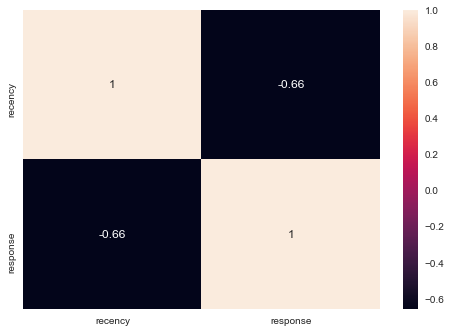

In [33]:
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H4. Customers with recency under 30 should buy more.
**False** - Total number of purchases is not affected by recency

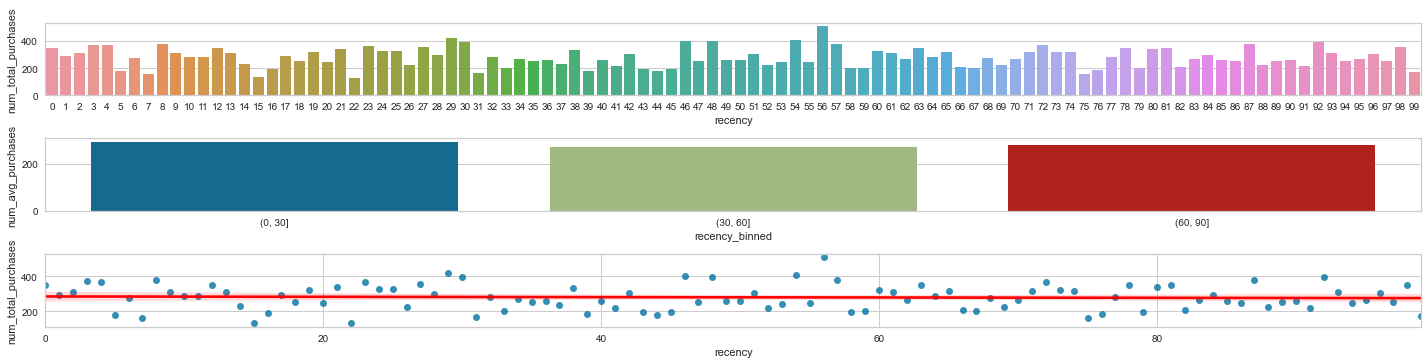

In [34]:
aux1 = df4[['recency', 'num_total_purchases']].groupby('recency').sum().reset_index()
bins=list(np.arange(0 ,120, 30))
aux1['recency_binned'] = pd.cut(aux1['recency'], bins=bins)

aux2 = aux1[['recency_binned', 'num_total_purchases']].groupby('recency_binned').mean().reset_index()

plt.figure(figsize=(20, 5))
plt.subplot(3, 1, 1)
sns.barplot(data=aux1, x='recency', y='num_total_purchases');

plt.subplot(3, 1, 2)
sns.barplot(data=aux2, x='recency_binned', y='num_total_purchases');
plt.ylabel('num_avg_purchases')

plt.subplot(3, 1, 3)
sns.regplot(data=aux1, x='recency', y='num_total_purchases', line_kws={'color':'red'});

plt.tight_layout()

<AxesSubplot:>

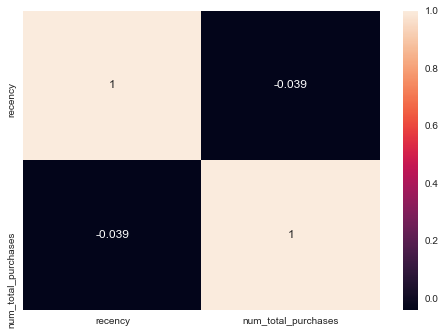

In [35]:
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### H5. Customer that enrolled since more time should accept the gadget.
**True** Customer that enrolled since more time accept the gadget

<AxesSubplot:>

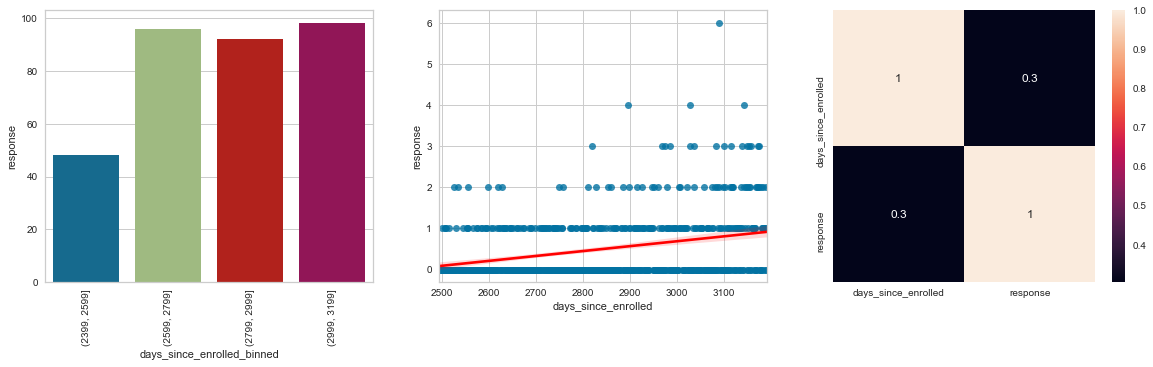

In [36]:
aux1 = df4[['days_since_enrolled', 'response']].groupby('days_since_enrolled').sum().reset_index()
bins = np.arange(2399, 3201, 200)
aux1['days_since_enrolled_binned'] = pd.cut(df4['days_since_enrolled'], bins=bins)

aux2 = aux1[['days_since_enrolled_binned', 'response']].groupby('days_since_enrolled_binned').sum().reset_index()

plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
sns.barplot(data=aux2, x='days_since_enrolled_binned', y='response');
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.regplot(data=aux1, x='days_since_enrolled', y='response', line_kws={'color':'red'})

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### H6. Customer that enrolled since more time buy more.
**False** - In fact, there is an average on purchasings.

<AxesSubplot:>

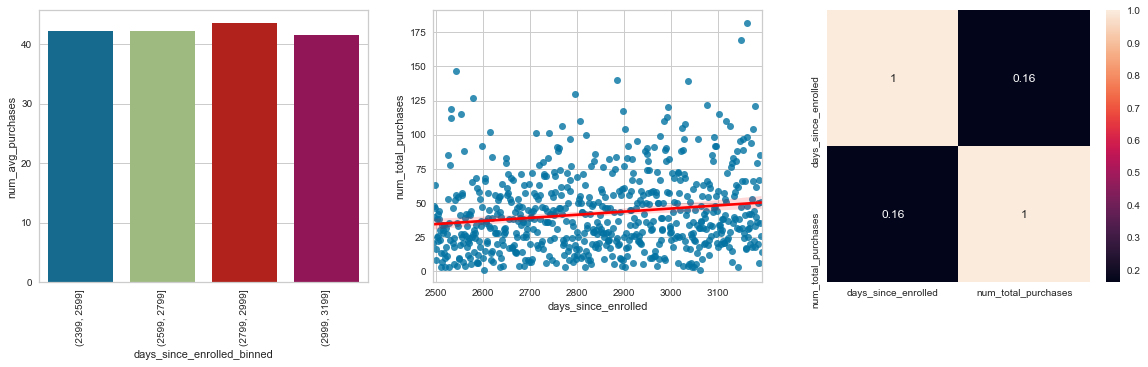

In [37]:
aux1 = df4[['days_since_enrolled', 'num_total_purchases']].groupby('days_since_enrolled').sum().reset_index()
bins = np.arange(2399, 3201, 200)
aux1['days_since_enrolled_binned'] = pd.cut(df4['days_since_enrolled'], bins=bins)

aux2 = aux1[['days_since_enrolled_binned', 'num_total_purchases']].groupby('days_since_enrolled_binned').mean().reset_index()

plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
sns.barplot(data=aux2, x='days_since_enrolled_binned', y='num_total_purchases');
plt.xticks(rotation=90);
plt.ylabel('num_avg_purchases')

plt.subplot(1, 3, 2)
sns.regplot(data=aux1, x='days_since_enrolled', y='num_total_purchases', line_kws={'color':'red'})

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### H7. Customers with higher education should accept the gadget.
**True** - Customers with higher education tend to accept the gadget

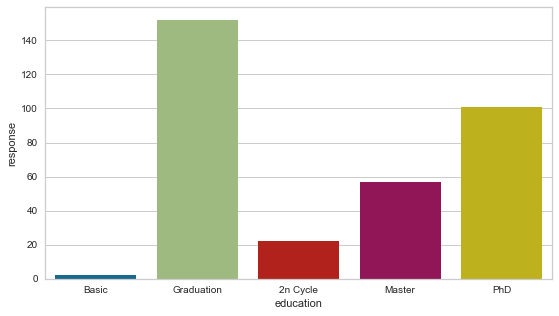

In [38]:
aux1 = df4[['education', 'response']].groupby('education').sum().reset_index()
aux1 = aux1.loc[[1, 2, 0, 3, 4], :].reset_index(drop=True)

plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
sns.barplot(data=aux1, x='education', y='response');

### H8. Customers with higher education buy more.
**True** - Customers with higher education tend to buy more.

Text(0, 0.5, 'num_avg_purchases')

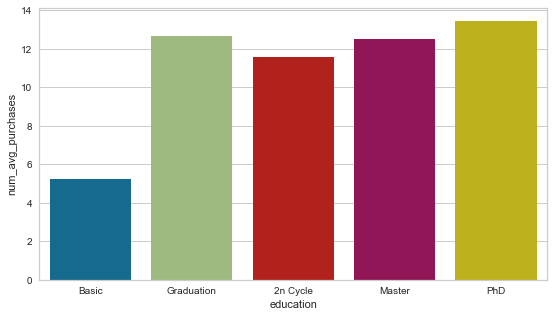

In [39]:
aux1 = df4[['education', 'num_total_purchases']].groupby('education').mean().reset_index()
aux1 = aux1.loc[[1, 2, 0, 3, 4], :].reset_index(drop=True)

plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
sns.barplot(data=aux1, x='education', y='num_total_purchases');
plt.ylabel('num_avg_purchases')

### H9. Customers with lower age accept the gadget.
**False** - We have a pick on central ages

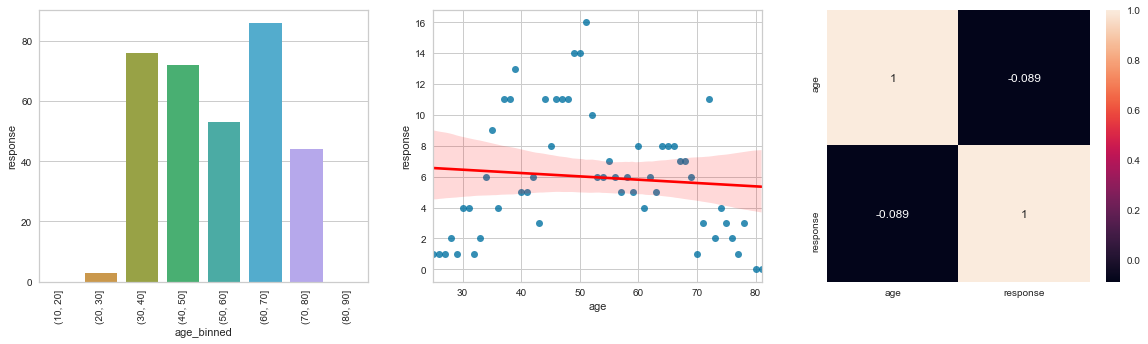

In [40]:
aux1 = df4[df4['age'] < 100][['age', 'response']].groupby('age').sum().reset_index()
bins = np.arange(10, 100, 10)
aux1['age_binned'] = pd.cut(df4['age'], bins=bins)

aux2 = aux1[['age_binned', 'response']].groupby('age_binned').sum().reset_index()

plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
sns.barplot(data=aux2, x='age_binned', y='response');
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.regplot(data=aux1, x='age', y='response', line_kws={'color':'red'});

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H10. Customers with lower age buy more.
**False** - Median age customer buy more.

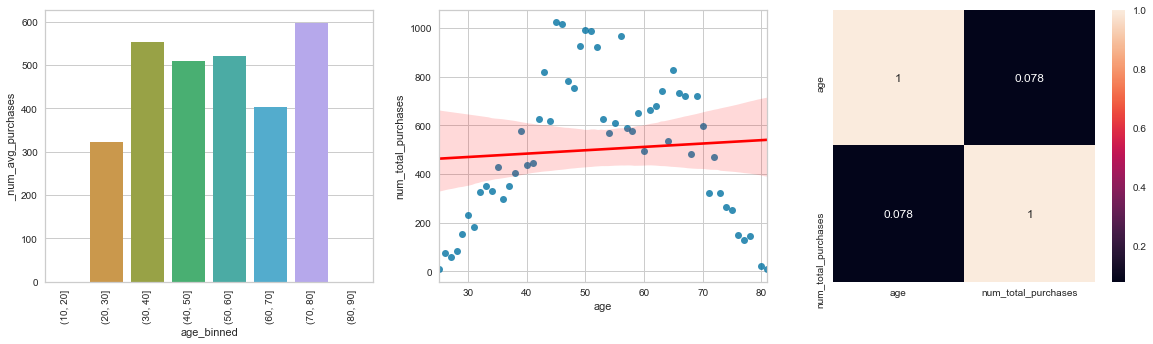

In [41]:
aux1 = df4[df4['age'] < 100][['age', 'num_total_purchases']].groupby('age').sum().reset_index()
bins = np.arange(10, 100, 10)
aux1['age_binned'] = pd.cut(df4['age'], bins=bins)

aux2 = aux1[['age_binned', 'num_total_purchases']].groupby('age_binned').mean().reset_index()

plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
sns.barplot(data=aux2, x='age_binned', y='num_total_purchases');
plt.xticks(rotation=90);
plt.ylabel('_num_avg_purchases')

plt.subplot(1, 3, 2)
sns.regplot(data=aux1, x='age', y='num_total_purchases', line_kws={'color':'red'});

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H11. Customers with higher income should accept the gadget.
**True** - Customers with higher income accept the gadget.

In [42]:
display(df4['income'].min(), df4['income'].max())

1730.0

162397.0

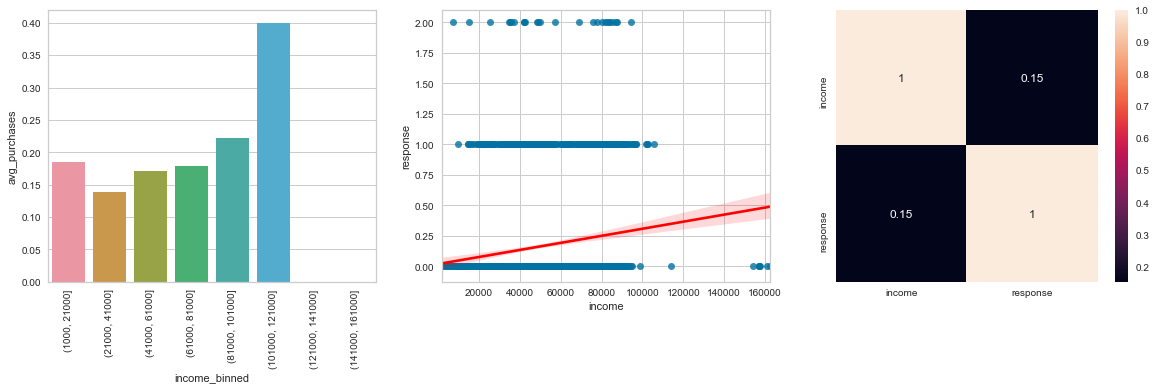

In [43]:
aux1 = df4[['income', 'response']].groupby('income').sum().reset_index()
bins = np.arange(1000, 170001, 20000)
aux1['income_binned'] = pd.cut(df4['income'], bins=bins)

aux2 = aux1[['income_binned', 'response']].groupby('income_binned').mean().reset_index()

plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
# sns.barplot(data=aux1, x='income', y='response');
sns.barplot(data=aux2, x='income_binned', y='response');
plt.xticks(rotation=90);
plt.ylabel('avg_purchases')

plt.subplot(1, 3, 2)
sns.regplot(data=aux1, x='income', y='response', line_kws={'color':'red'});

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H12. Customers with higher-income should buy more.
**False** - On average, Customers with higher income buy less

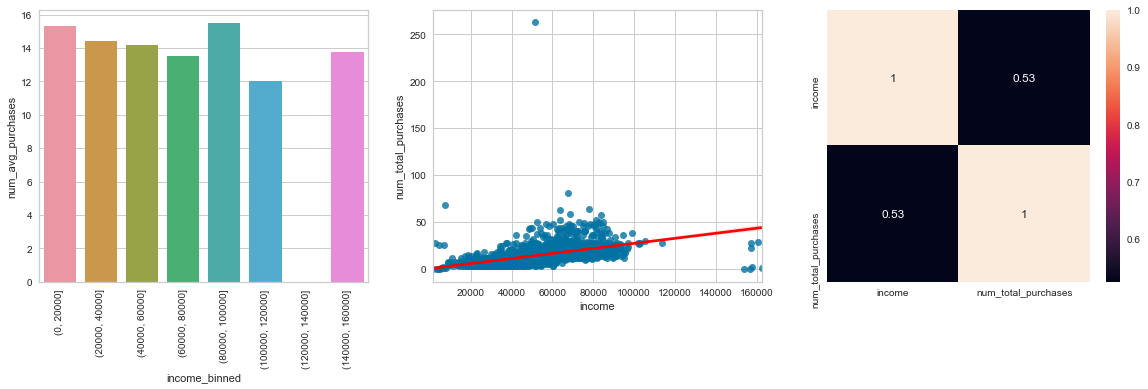

In [44]:
aux1 = df4[['income', 'num_total_purchases']].groupby('income').sum().reset_index()
bins = np.arange(0, 170001, 20000)
aux1['income_binned'] = pd.cut(df4['income'], bins=bins)

aux2 = aux1[['income_binned', 'num_total_purchases']].groupby('income_binned').mean().reset_index()

plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
# sns.barplot(data=aux1, x='income', y='response');
sns.barplot(data=aux2, x='income_binned', y='num_total_purchases');
plt.xticks(rotation=90);
plt.ylabel('num_avg_purchases')

plt.subplot(1, 3, 2)
sns.regplot(data=aux1, x='income', y='num_total_purchases', line_kws={'color':'red'});

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H13. Customers that often visit the store website should accept the gadget.
**True** - We have growing curve with a peak on 8 visits, followed by a abrupt fall.

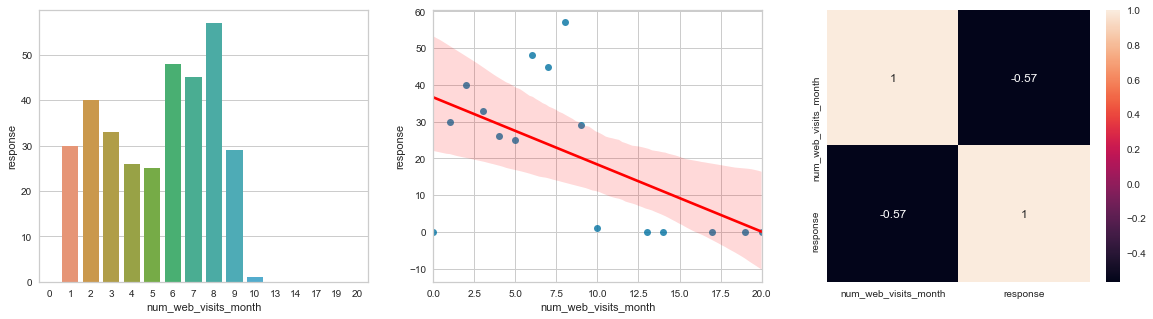

In [45]:
aux1 = df4[['num_web_visits_month', 'response']].groupby('num_web_visits_month').sum().reset_index()

plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
sns.barplot(data=aux1, x='num_web_visits_month', y='response');
plt.xticks(rotation=0);

plt.subplot(1, 3, 2)
sns.regplot(data=aux1, x='num_web_visits_month', y='response', line_kws={'color':'red'});

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H14. Customers that often visit the store website buy more.
**True** - We have growing curve with a peak on 6 visits, followed by a abrupt fall.

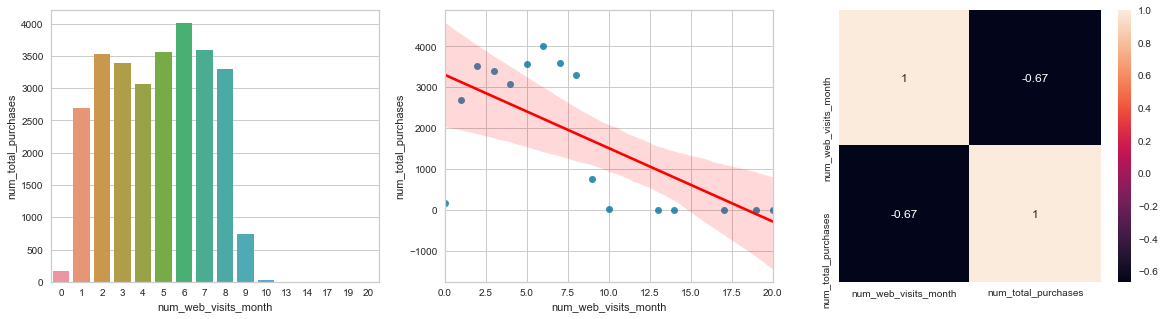

In [46]:
aux1 = df4[['num_web_visits_month', 'num_total_purchases']].groupby('num_web_visits_month').sum().reset_index()

plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
sns.barplot(data=aux1, x='num_web_visits_month', y='num_total_purchases');
# sns.barplot(data=aux2, x='num_web_visits_month_binned', y='num_total_purchases');
plt.xticks(rotation=0);

plt.subplot(1, 3, 2)
sns.regplot(data=aux1, x='num_web_visits_month', y='num_total_purchases', line_kws={'color':'red'});

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H15. Customers that are single should accept the gadget.
**True** - Customers that are single accept the gadget.

Text(0, 0.5, 'avg_response')

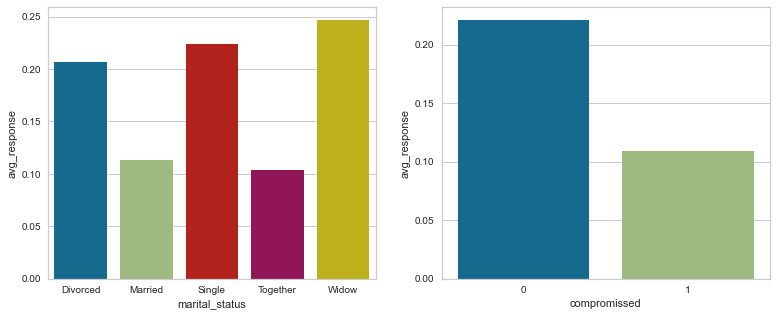

In [47]:
aux1 = df4[['marital_status', 'response']].groupby('marital_status').mean().reset_index()

plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
sns.barplot(data=aux1, x='marital_status', y='response');
plt.xticks(rotation=0);
plt.ylabel('avg_response')

plt.subplot(1, 3, 2)
aux2 = df4[['compromissed', 'response']].groupby('compromissed').mean().reset_index()
sns.barplot(data=aux2, x='compromissed', y='response');
plt.ylabel('avg_response')

### H16. Customers that are single should buy more.
**False** - We see an average comportament independent of the marital status

Text(0, 0.5, 'num_avg_purchases')

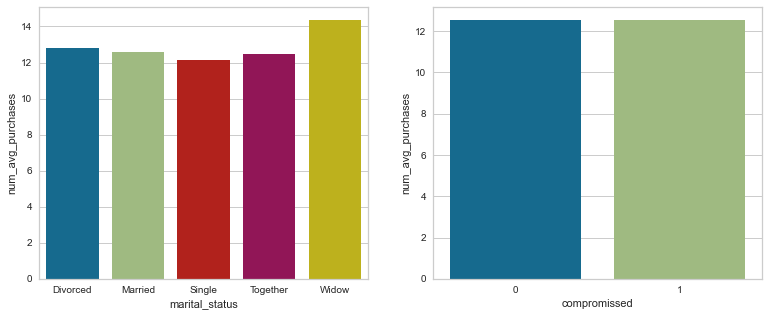

In [48]:
aux1 = df4[['marital_status', 'num_total_purchases']].groupby('marital_status').mean().reset_index()

plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
sns.barplot(data=aux1, x='marital_status', y='num_total_purchases');
plt.xticks(rotation=0);
plt.ylabel('num_avg_purchases')

plt.subplot(1, 3, 2)
aux2 = df4[['compromissed', 'num_total_purchases']].groupby('compromissed').mean().reset_index()
sns.barplot(data=aux2, x='compromissed', y='num_total_purchases');
plt.ylabel('num_avg_purchases')

### H17. Customers with more kids in household should accept the gadget.
**False** - Customers with more kids in household don't accept the gadget.

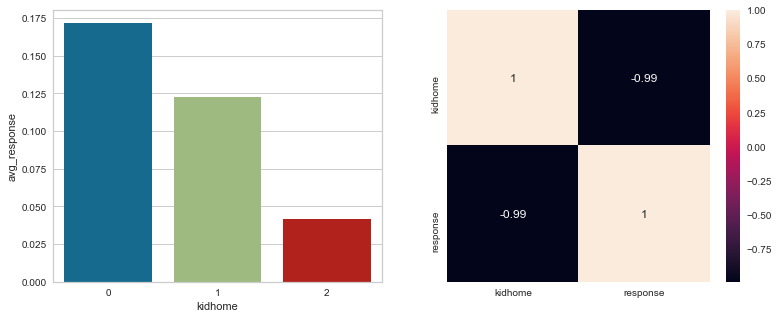

In [49]:
aux1 = df4[['kidhome', 'response']].groupby('kidhome').mean().reset_index()

plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
sns.barplot(data=aux1, x='kidhome', y='response');
plt.xticks(rotation=0);
plt.ylabel('avg_response')

plt.subplot(1, 3, 2)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H18. Customers with more kids in household should buy more.
**False** - Customers with more kids in household buy less.

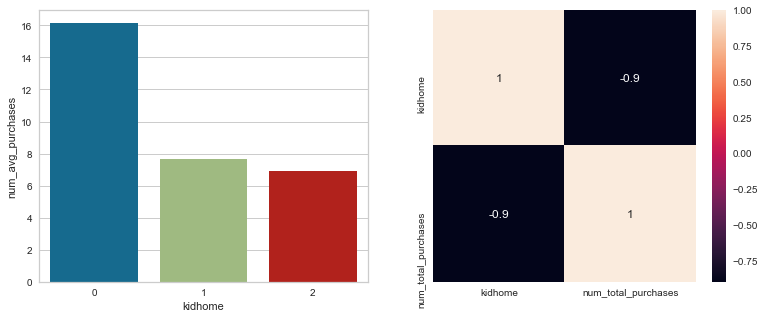

In [50]:
aux1 = df4[['kidhome', 'num_total_purchases']].groupby('kidhome').mean().reset_index()

plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
sns.barplot(data=aux1, x='kidhome', y='num_total_purchases');
plt.xticks(rotation=0);
plt.ylabel('num_avg_purchases')

plt.subplot(1, 3, 2)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H19. Customers with more teenagers in household should accept the gadget.
**False** - Customers with more tennagers in household don't accept the gadget.

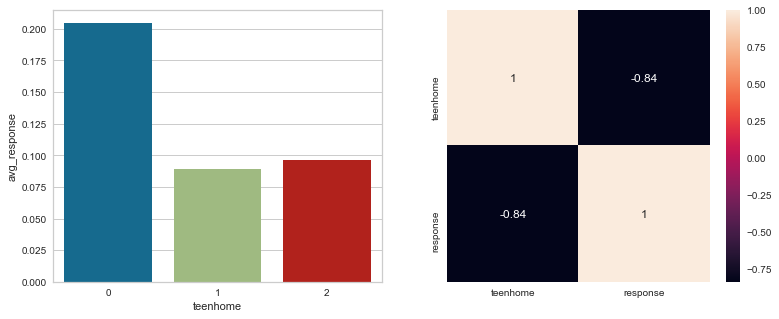

In [51]:
aux1 = df4[['teenhome', 'response']].groupby('teenhome').mean().reset_index()

plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
sns.barplot(data=aux1, x='teenhome', y='response');
plt.xticks(rotation=0);
plt.ylabel('avg_response')

plt.subplot(1, 3, 2)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H20. Customers with more teenagers in household should buy more.
**True** - Customers with more teenagers in household should buy more.

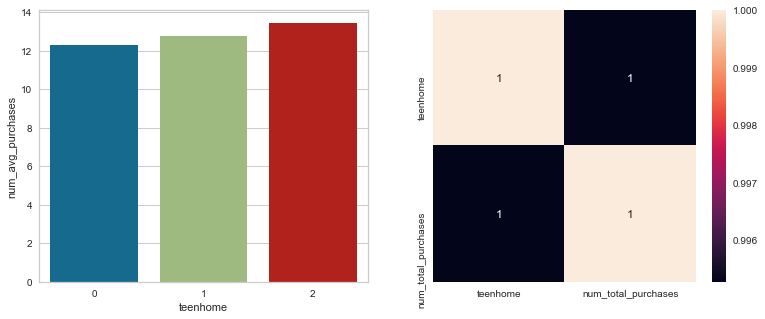

In [52]:
aux1 = df4[['teenhome', 'num_total_purchases']].groupby('teenhome').mean().reset_index()

plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
sns.barplot(data=aux1, x='teenhome', y='num_total_purchases');
plt.xticks(rotation=0);
plt.ylabel('num_avg_purchases')

plt.subplot(1, 3, 2)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H21. Customers that often complains shouldn't accept the gadget.
**True** -  Customers that often complains tend to not accept the gadget.

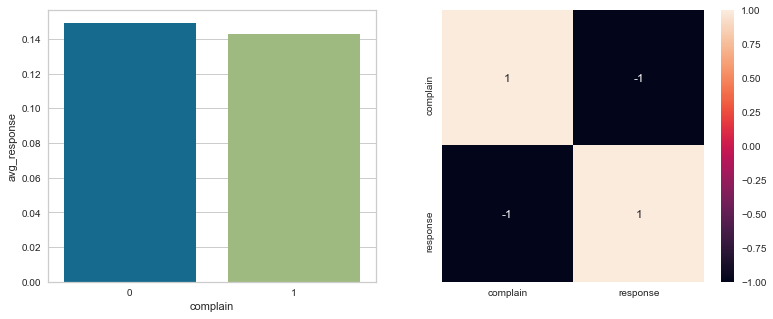

In [53]:
aux1 = df4[['complain', 'response']].groupby('complain').mean().reset_index()

plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
sns.barplot(data=aux1, x='complain', y='response');
plt.xticks(rotation=0);
plt.ylabel('avg_response')

plt.subplot(1, 3, 2)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H22. Customers that often complains tend to buy less.
**True** - Customers that often complains tend to buy less.

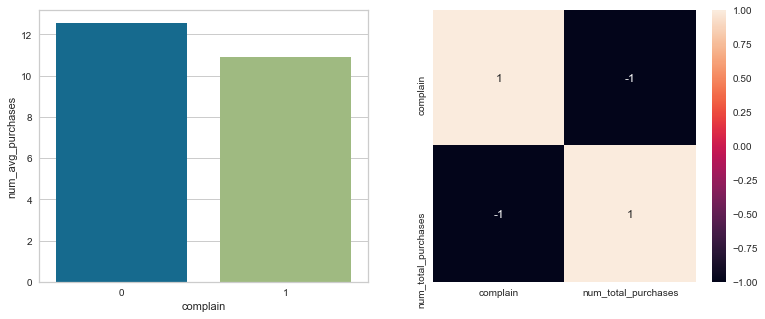

In [54]:
aux1 = df4[['complain', 'num_total_purchases']].groupby('complain').mean().reset_index()

plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
sns.barplot(data=aux1, x='complain', y='num_total_purchases');
plt.xticks(rotation=0);
plt.ylabel('num_avg_purchases')

plt.subplot(1, 3, 2)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

## 4.3. Multivariate Analysis

### 4.3.1. Numerical Variable

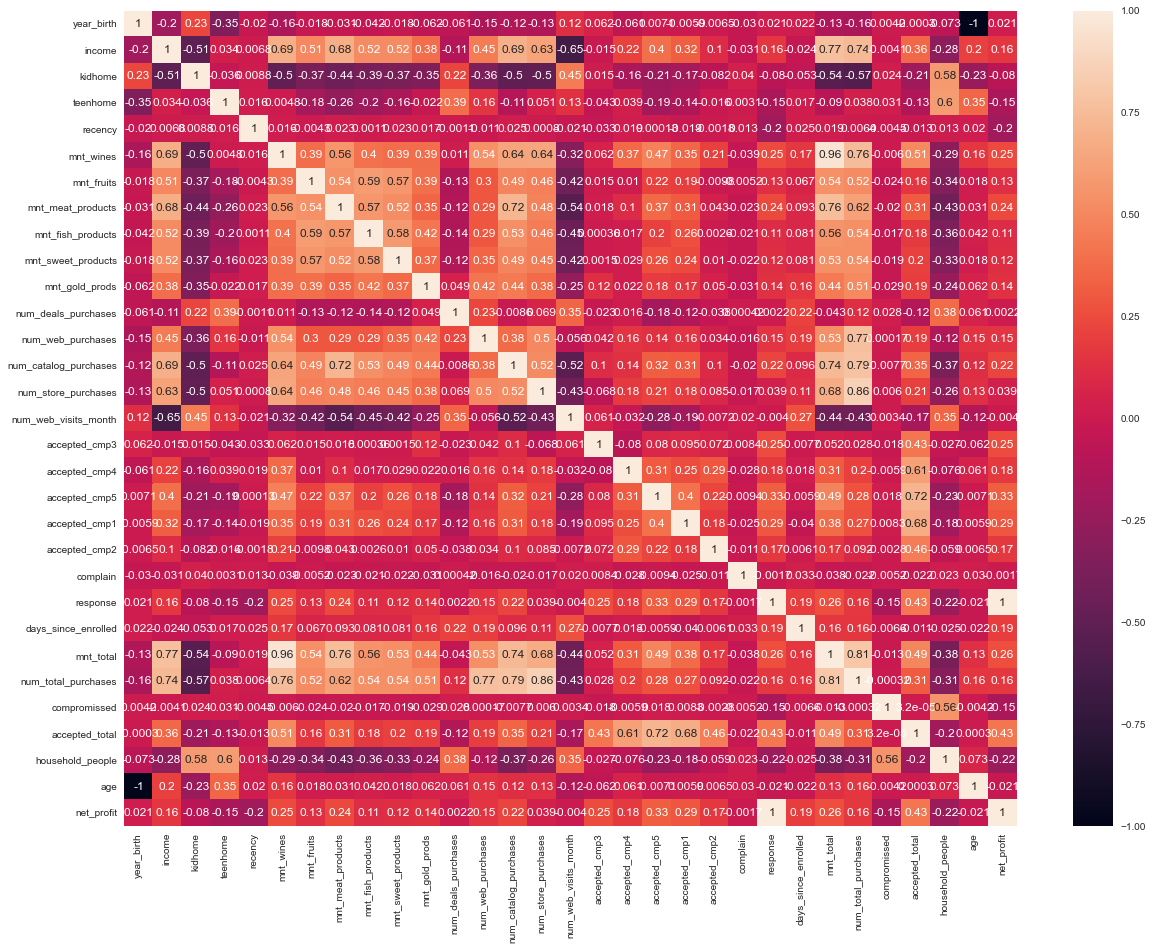

In [55]:
plt.figure(figsize=(20,15))
sns.heatmap(num_attributes.corr(method='pearson'), annot=True);

### 4.3.2. Categorical Variable

In [56]:
a = df4.select_dtypes(include=['object'])
a.head()

,education,marital_status
0,Graduation,Single
1,Graduation,Single
2,Graduation,Together
3,Graduation,Together
4,PhD,Married


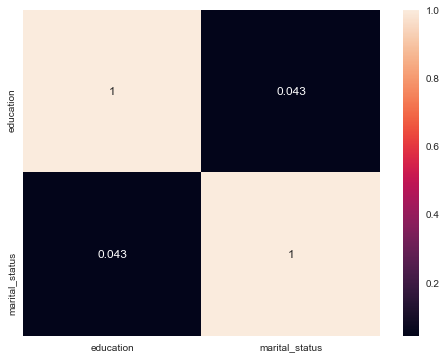

In [57]:
d = pd.DataFrame()
aux = []
for i in a.columns:
    for j in a.columns:
        v = cramerv(a[i], a[j])
        aux.append(v)
    d[i] = aux.copy()
    aux.clear()
d = d.set_index(d.columns)

plt.figure(figsize=(8,6))
sns.heatmap(d, annot=True);

# 5. DATA PREPARATION

In [58]:
df5 = df4.copy()

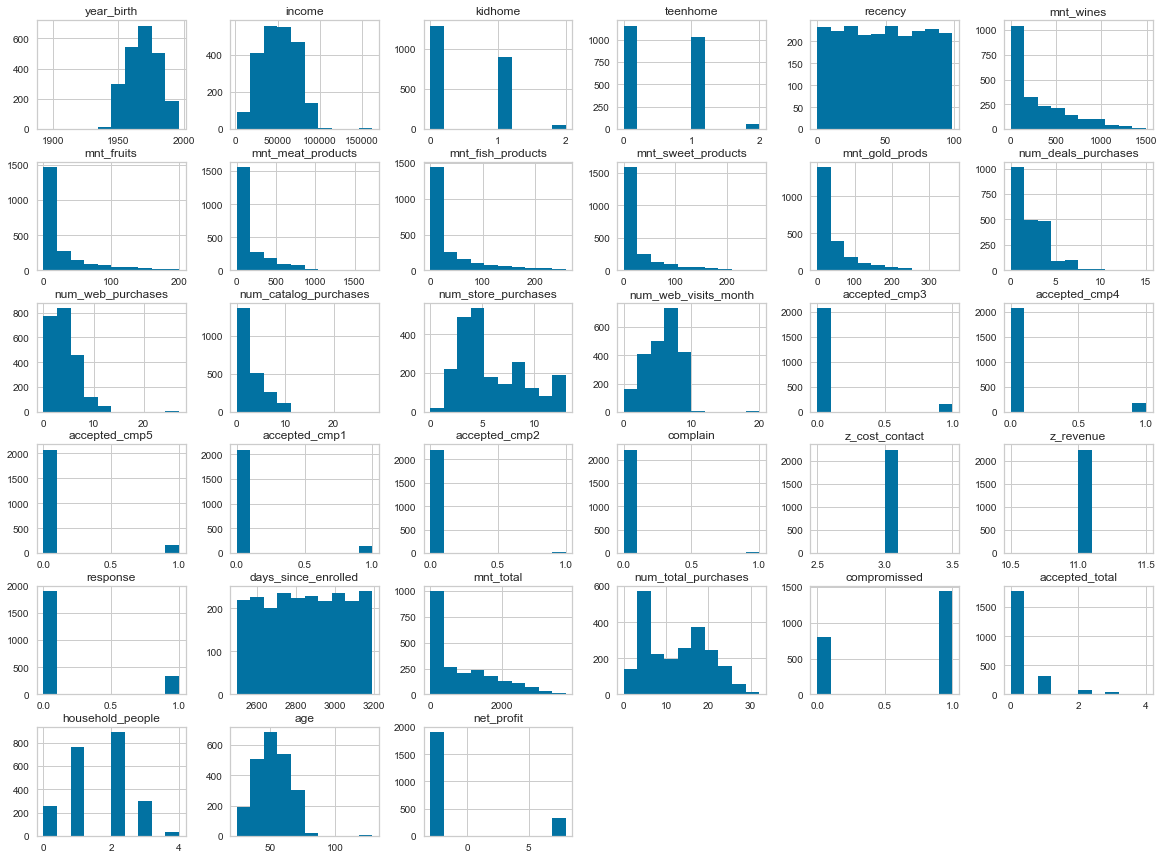

In [59]:
df5.hist(figsize=(20,15));

## 5.1. Standardization

In [60]:
# not used in this project

## 5.2. Rescaling

In [61]:
rs = RobustScaler()
cols = df5.select_dtypes(include=['int64', 'float64']).drop(columns=['z_revenue', 'z_cost_contact', 'net_profit', 'compromissed', 'household_people']).columns

In [62]:
for i in cols:
    df5[[i]] = rs.fit_transform(df5[[i]])
    pickle.dump(rs, open('./preprocessing/robust_scaler_{}.pkl'.format(i), 'wb'))

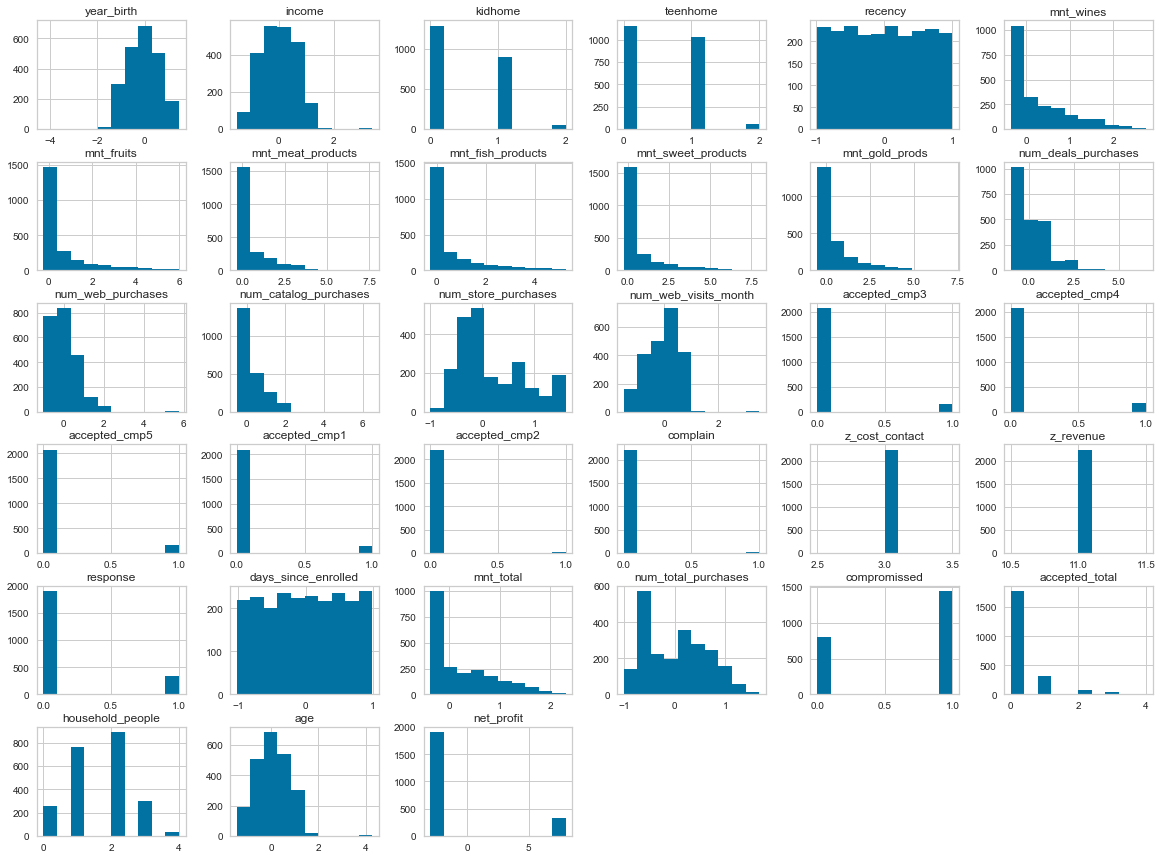

In [63]:
df5.hist(figsize=(20,15));

## 5.3. Transformation

### 5.3.1 Encoding

In [64]:
# ordinal encoding
education_dict = {'Basic': 1, '2n Cycle': 2, 'Graduation': 3, 'Master': 4, 'PhD': 5}
df5['education'] = df5['education'].map(education_dict)

In [65]:
# OneHot Encoding
df5 = pd.get_dummies(df5, columns=['marital_status'])

### 5.3.2 Response Variable Transformation

In [66]:
# not used in this project

# 6. FEATURE SELECTION

In [67]:
df6 = df5.copy()

## 6.1. Split DataFrame into training and test dataset

In [68]:
X = df6.drop(['response', 'year_birth', 'z_cost_contact', 'z_revenue', 'net_profit'], axis=1)
y = df6['response']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [69]:
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1568, 34)

(672, 34)

(1568,)

(672,)

## 6.2. Boruta as Feature Selector

In [70]:
# Define RandomForestRegressor
rf = RandomForestClassifier(n_jobs=-1)

X_train_boruta = X_train.values
y_train_boruta = y_train.values

# Define boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_boruta, y_train_boruta)

### 6.2.1. Best Features From Boruta

In [71]:
cols_selected = boruta.support_.tolist()
cols_selected_boruta = list(X_train.loc[:, cols_selected].columns)

In [72]:
cols_selected = ['education', 'income', 'recency', 'mnt_total', 'complain',
                 'num_total_purchases', 'accepted_total', 'household_people',
                 'age', 'days_since_enrolled']

In [73]:
X_train = X_train[cols_selected]
X_test = X_test[cols_selected]

# 7. MACHINE LEARNING MODELING

## 7.1. Random Forest Classifier

In [74]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
yhat_rf = rf.predict(X_test)

rf_result = ml_error('RandomForestClassifier', y_test, yhat_rf)
rf_result

,model_name,accuracy
0,RandomForestClassifier,0.875


### 7.1.1. Random Forest Classifier - Cross Validation

In [75]:
rf_result_cv = cross_validation(rf, 'RandonForestClassifier', X, y)
rf_result_cv

,model_name,final_score
0,RandonForestClassifier,0.890179


## 7.2. XGBoost Classifier

In [76]:
xgb = XGBClassifier(random_state=42, use_label_encoder=False)
xgb.fit(X_train, y_train)
yhat_xgb = xgb.predict(X_test)

xgb_result = ml_error('XGBClassifier', y_test, yhat_xgb)
xgb_result

[08:03:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


,model_name,accuracy
0,XGBClassifier,0.857143


### 7.2.1. XGBoost Classifier - Cross Validation

In [77]:
xgb_result_cv = cross_validation(xgb, 'XGBClassifier', X, y)
xgb_result_cv

[08:03:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[08:03:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:03:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:03:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:03:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

,model_name,final_score
0,XGBClassifier,0.890625


## 7.3. Compare Model's Performance

In [78]:
pd.concat([rf_result_cv, xgb_result_cv], ignore_index=True, axis=0)

,model_name,final_score
0,RandonForestClassifier,0.890179
1,XGBClassifier,0.890625


In [79]:
xgb = xgb.fit(X[cols_selected], y)
rf = rf.fit(X[cols_selected], y)

[08:03:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [80]:
pickle.dump(xgb, open('./model/XGBClassifier.pkl', 'wb'))
pickle.dump(rf, open('./model/RandomForestClassifier.pkl', 'wb'))

## 7.4. Clustering

### 7.4.1. Within-Cluster Sum of Squares (WSS)

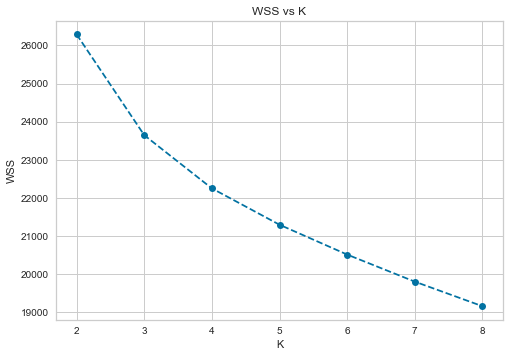

In [81]:
clusters = [2, 3, 4, 5, 6, 7, 8]

# aux1 = pd.concat([X, y], axis=1)
aux1 = X
wss = []
for k in clusters:
    # model definition
    kmeans = KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)
    
    # training
    kmeans.fit(aux1)
    
    # validation
    wss.append(kmeans.inertia_)

# plot wss
plt.plot(clusters, wss, linestyle='--', marker='o', color='b');
plt.xlabel('K')
plt.ylabel('WSS')
plt.title('WSS vs K');

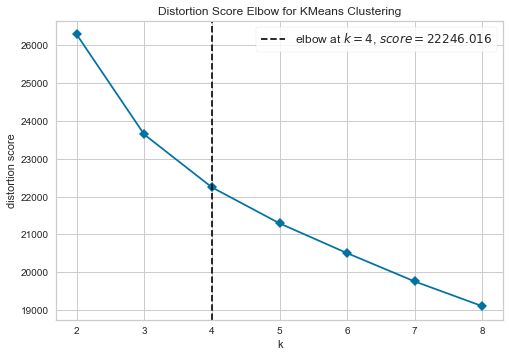

In [82]:
kmeans = KElbowVisualizer(KMeans(), k=clusters, timings=False)
kmeans.fit(aux1)
kmeans.show();

### 7.4.2. Silhouette Score (SS)

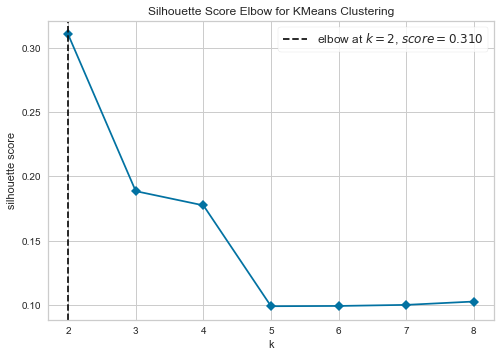

In [83]:
kmeans = KElbowVisualizer(KMeans(), k=clusters, timings=False, metric='silhouette')
kmeans.fit(aux1)
kmeans.show();

In [84]:
aux1.sample()

,education,income,kidhome,teenhome,recency,mnt_wines,mnt_fruits,mnt_meat_products,mnt_fish_products,mnt_sweet_products,mnt_gold_prods,num_deals_purchases,num_web_purchases,num_catalog_purchases,num_store_purchases,num_web_visits_month,accepted_cmp3,accepted_cmp4,accepted_cmp5,accepted_cmp1,accepted_cmp2,complain,days_since_enrolled,mnt_total,num_total_purchases,compromissed,accepted_total,household_people,age,marital_status_Divorced,marital_status_Married,marital_status_Single,marital_status_Together,marital_status_Widow
609,3,0.909873,0.0,0.0,0.7,0.492196,-0.25,2.430556,2.87234,0.4375,-0.042553,-0.5,0.5,0.5,0.4,-0.75,0.0,0.0,0.0,1.0,0.0,0.0,-0.868629,0.756486,0.416667,1,1.0,1,0.277778,0,1,0,0,0


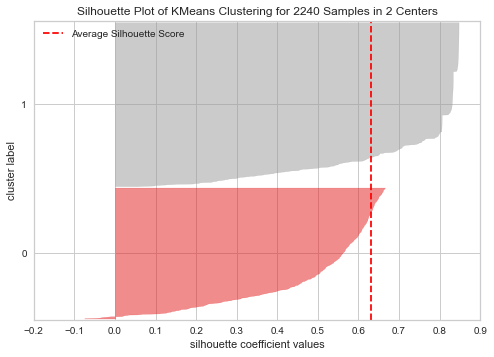

In [94]:
cols = ['mnt_total', 'num_total_purchases']
# aux1 = pd.concat([X[cols], y, axis=1)
aux1 = X[cols]
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=42)
visualizer = SilhouetteVisualizer(kmeans)
visualizer.fit(aux1)
visualizer.finalize()

## 7.5. Cluster Profile

In [120]:
aux1 = df4[cols_selected]
labels = kmeans.labels_

aux1['label'] = labels
aux2 = pd.DataFrame(aux1['label'].value_counts())
aux2.columns = ['count']
aux2

<ipython-input-120-b4f4978a97cf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux1['label'] = labels


,count
1,1245
0,995


In [114]:
# average values to features
aux3 = aux1.groupby('label').mean().reset_index()
aux4 = pd.concat([aux3, aux2], axis=1)
aux4

,label,income,recency,mnt_total,complain,num_total_purchases,accepted_total,household_people,age,days_since_enrolled,count
0,0,69752.303518,49.341709,1704.166834,0.008040,19.465327,0.554774,1.249246,54.203015,2872.261307,995
1,1,37746.376305,48.923695,195.621687,0.010442,7.000000,0.092369,1.871486,50.588755,2827.858635,1245


# 8. HYPERPARAMETER FINE TUNING

In [87]:
param = {'n_estimators': [1500, 1700, 2500, 3000, 3500],
         'learning_rate': [0.01, 0.03],
         'max_depth': [3, 5, 9],
         'subsample': [0.1, 0.5, 0.7],
         'colsample_bytree': [0.3, 0.7, 0.9],
         'min_child_weight': [3, 8, 15]}

MAX_EVAL = 10

In [88]:
final_result = pd.DataFrame()

for i in range(MAX_EVAL):
    
    # chose values for parameters randomly
    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
    print(hp)
    # model
    model_xgb = XGBClassifier(objective='binary:logistic',
                                 n_estimators=hp['n_estimators'],
                                 learning_rate=hp['learning_rate'],
                                 max_depth=hp['max_depth'],
                                 subsample=hp['subsample'],
                                 colsample_bytree=hp['colsample_bytree'],
                                 min_child_weight=hp['min_child_weight'])

    # performance
    result = cross_validation(xgb, 'XGBClassifier', X, y)
    final_result = pd.concat([final_result, result])
final_result

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


{'n_estimators': 1500, 'learning_rate': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 3}
[08:03:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:03:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:03:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly s

,model_name,final_score
0,XGBClassifier,0.890625
0,XGBClassifier,0.890625
0,XGBClassifier,0.890625
0,XGBClassifier,0.890625
0,XGBClassifier,0.890625
0,XGBClassifier,0.890625
0,XGBClassifier,0.890625
0,XGBClassifier,0.890625
0,XGBClassifier,0.890625
0,XGBClassifier,0.890625


# 9. TRANSLATION AND INTERPRETATION OF THE ERROR

In [89]:
df9 = df4.copy()

## 9.1. Business Performance

In [98]:
aux1 = df9[['response', 'z_cost_contact', 'z_revenue', 'net_profit']]
aux1['predictions'] = rf.predict(X[cols_selected])
aux1['net_profit_predicted'] = aux1.apply(lambda x: 0 if x['predictions'] == 0
                                          else (x['response'] * x['z_revenue'] - x['z_cost_contact']), axis=1)

<ipython-input-98-2bc9767007de>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux1['predictions'] = rf.predict(X[cols_selected])
<ipython-input-98-2bc9767007de>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux1['net_profit_predicted'] = aux1.apply(lambda x: 0 if x['predictions'] == 0


In [99]:
aux1.groupby('response').sum().reset_index()

,response,z_cost_contact,z_revenue,net_profit,predictions,net_profit_predicted
0,0,5718,20966,-5718,6.0,-18.0
1,1,1002,3674,2672,320.0,2560.0


In [100]:
aux2 = pd.DataFrame(aux1[['net_profit', 'net_profit_predicted']].sum()).T
aux2

,net_profit,net_profit_predicted
0,-3046.0,2542.0


<BarContainer object of 2 artists>

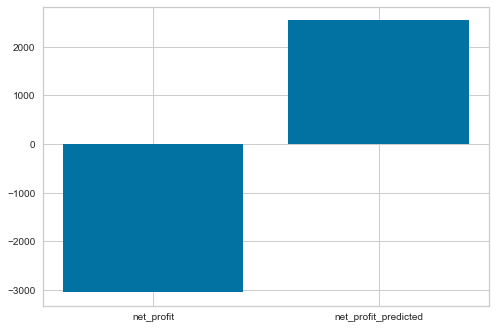

In [101]:
plt.bar(x=aux2.columns.tolist(), height=aux2.values[0].tolist(), )

# 10. DEPLOY MODEL TO PRODUCTION

## 10.1 Class

In [ ]:
import pandas as pd
import pickle
import inflection
import numpy as np
import sklearn
from datetime import datetime

class ifoodmodel:
    def __init__(self):
        pass
    
    def data_cleaning(self, df1):
        
        def snakecase(columns):
            return [inflection.underscore(column) for column in columns]
        
        cols_old = df1.columns
        cols_new = snakecase(cols_old)
        df1.columns = cols_new
        
        ## 10.2 API Handler

        # apply median to income's nan and outlier
        df1.loc[(df1['income'] > 400000) | (df1['income'].isna()), 'income'] = df1['income'].median()

        ## 1.6. Change Types

        df1['dt_customer'] = pd.to_datetime(df1['dt_customer'])
        
        return df1
       
    
    def feature_engineering(self, df2):
        ## 2.3. Feature Engineering

        # days since enrolled
        df2['days_since_enrolled'] = df2['dt_customer'].apply(lambda x: (x - datetime.today()).days * -1)

        # total spent in products
        df2['mnt_total'] = df2['mnt_wines'] + df2['mnt_wines'] + df2['mnt_fruits'] + df2['mnt_meat_products'] + df2['mnt_fish_products']  + df2['mnt_sweet_products']

        # total number of purchases
        df2['num_total_purchases'] = df2['num_web_purchases'] + df2['num_catalog_purchases'] + df2['num_store_purchases']

        # compromissed
        # I wil assume the follow about marital status
        marital_dict = {'Absurd': 0, 'Alone': 0, 'Divorced': 0, 'Married': 1, 'Single': 0, 'Together': 1, 'Widow': 0, 'YOLO': 0}
        df2['compromissed'] = df2['marital_status'].map(marital_dict)
        df2.loc[df2['marital_status'] == 'Absurd', 'marital_status'] = 'Single'
        df2.loc[df2['marital_status'] == 'Alone', 'marital_status'] = 'Single'
        df2.loc[df2['marital_status'] == 'YOLO', 'marital_status'] = 'Single'

        # accept total
        df2['accepted_total'] = df2['accepted_cmp1'] + df2['accepted_cmp2'] + df2['accepted_cmp3'] + df2['accepted_cmp4'] + df2['accepted_cmp5']

        # total household_people
        df2['household_people'] = df2['kidhome'] + df2['teenhome'] + df2['compromissed']

        # Age
        df2['age'] = datetime.today().year - df2['year_birth']
        
        cols_drop = ['id', 'dt_customer']
        df2 = df2.drop(cols_drop, axis=1)
        
        return df2
    
    
    def data_preparation(self, df5):
        cols = df5.select_dtypes(include=['int64', 'float64']).drop(columns=['z_revenue', 'z_cost_contact', 'compromissed', 'household_people']).columns

        # loading and applying scalers
        for col in cols:
            rs = pickle.load(open('./preprocessing/robust_scaler{}.pkl'.format(col), 'rb'))
            df5[[col]] = rs.transform(df5[[col]])    
                    
        # ordinal encoding
        education_dict = {'Basic': 1, '2n Cycle': 2, 'Graduation': 3, 'Master': 4, 'PhD': 5}
        df5['education'] = df5['education'].map(education_dict)

        # OneHot Encoding
        df5 = pd.get_dummies(df5, columns=['marital_status'])
        
        cols_selected = ['education', 'income', 'recency', 'mnt_total', 'complain',
                 'num_total_purchases', 'accepted_total', 'household_people',
                 'age', 'days_since_enrolled']
        
        return df5[cols_selected]
    
    
    def get_prediction(self, original_data, test_data):
        # loading model
        model = pickle.load(open('./model/RandomForestClassifier.pkl', 'rb'))
        
        # prediction
        pred = model.predict(test_data)
        
        # join into the original data
        original_data['prediction'] = pred
        
        return original_data.to_json(orient='records', date_format='iso')

## 10.2. API Handler

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from webapp.ifood.ifood import ifoodmodel
import os

#loading model
model = pickle.load(open('./webapp/model/RandomForestClassifier.pkl', 'rb'))

app = Flask(__name__)

@app.route('/ifood/predict', methods=['POST'])
def ifood_predict():
    test_json = request.get_json()


    if test_json:
        if isinstance(test_json, dict):
            test_raw = pd.DataFrame(test_json, index=[0]) # unique example
        else:
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys()) # multiple example

        #instaciating ifoodmodel class
        pipeline = ifoodmodel()

        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)

        # feature engineering
        df2 = pipeline.feature_engineering(df1)

        # data preparation
        df3 = pipeline.data_preparation(df2)

        # predictions
        df_response = pipeline.get_prediction(model, test_raw, df3)

        return df_response
    
    else:
        return Response('{}', status=200, mimetype='aplication/json')

if __name__ == '__main__':
    port = os.environ.get('PORT', 5000)
    app.run('0.0.0.0', port=port)

## 10.3. API Tester

In [ ]:
import json
import requests

# loading test dataset
df10 = df0.drop('Response', axis=1)

# choose store for prediction
# df10 = df10[df10['ID'].isin([2968, 1509])]

In [ ]:
# convert DataFrame to json
data = json.dumps(df10.to_dict(orient='records'))

In [ ]:
# API call
# url = 'http://127.0.0.1:5000/ifood/predict'
url = 'http://al-ifood.herokuapp.com/ifood/predict' # Heroku
header = {'Content-type': 'application/json'}

r = requests.post(url, data=data, headers=header)
print('Status code: {}'.format(r.status_code))

In [ ]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [ ]:
d1[d1['prediction'] == 1]

In [ ]:
customers = [2968, 1509]
d2 = d1[d1['id'].isin([2968, 1509])].reset_index()

In [ ]:
for i in range(len(d2)):
    print('Customer number {}: {}'.format(d2['id'][i], d2['prediction'][i].astype('int64')))